# About
This notebook calculates

* Aligned scattering curves between IDPFold and STARLING with experimental data on the same axis
* The $R_g$ distribution associated with the IDPFold ensemble with the experimental value superimposed on top.

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import matplotlib
import matplotlib as mpl

mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1

mpl.rcParams['xtick.major.size'] = 2  # Major tick length for x-axis
mpl.rcParams['xtick.minor.size'] = 0.5   # Minor tick length for x-axis
mpl.rcParams['ytick.major.size'] = 2  # Major tick length for y-axis
mpl.rcParams['ytick.minor.size'] = 0.5   # Minor tick length for y-axis

mpl.rcParams['xtick.major.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.major.width'] = 0.375  # Major tick width for y-axis
mpl.rcParams['xtick.minor.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.minor.width'] = 0.375  # Major tick width for y-axis


	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.375

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)
from tqdm.auto import tqdm
import pickle

In [18]:
 ## Initial pre-amble for making nice figures
import os
import numpy as np
import matplotlib
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import string  
import protfasta

from starling import load_ensemble
from soursop.sstrajectory import SSTrajectory

# NB: we (holehouse lab) have an internal package which includes a set of internal
# tools called housetools; if we are running this internally, the following code allows
# us to rebuild the "aligned" curves from the ensembles. However, it's worth noting
# all this is code the aligns experimental an simulated scattering curves to ensure I(q)
# values match up, so nothing fancy! If you're regenerating the figures there is no need
# to do this the pre-aligned curves are provided as pickle files.
REALIGN_WITH_HOUSETOOLS=True
if REALIGN_WITH_HOUSETOOLS:
    from housetools.methods import saxs


In [19]:
def get_clean_filename(input_name, directory):
    """
    Check if there's a file with the suffix '_clean.dat' in the directory.
    If such a file exists, return its path; otherwise, return the directory.
    
    Args:
        input_name (str): The base name to check for '_clean.dat' suffix.
        directory (str): The directory to search.
    
    Returns:
        str: The full path to the '_clean.dat' file if found, otherwise the directory.
    """
    # Construct the potential '_clean.dat' filename

    input_name_no_extension = input_name[:-4]
    
    clean_filename = f"{input_name_no_extension}_clean.dat"    
    clean_filepath = os.path.join(directory, clean_filename)

    # Check if the file exists
    if os.path.isfile(clean_filepath):
        return clean_filepath
    elif os.path.isfile(os.path.join(directory, input_name)):
        return os.path.join(directory, input_name)
    else:
        print(os.path.join(directory, input_name))
        raise Exception('Could not find file')    

def read_pickle(fn):
    """Reads a pickle file and returns the stored object."""
    with open(fn, "rb") as f:
        return pickle.load(f)

def write_pickle(fn, outdict):
    """Writes a dictionary (or any object) to a pickle file."""
    with open(fn, "wb") as f:
        pickle.dump(outdict, f, protocol=pickle.HIGHEST_PROTOCOL)              

In [20]:
names = ['dCh_minus', 'dTRBP', 'sNh_plus', 'sNrich']
seqs = {} 

seqs['dCh_minus'] = 'GSGSCMGLPTGMEEKEEGTDESEQKPVVQTPAQPDDSAEVDSAALDQAESAKQQGPILTKHGCTLGPR'
seqs['dTRBP'] = 'GSGSCLEPALEDSSSFSPLDSSLPEDIPVFTAAAAATPVPSVVLTRSPPMELQPPVSPQQSECTLGPR'
seqs['sNh_plus'] = 'GSGSCPEEIETRKKDRKNRREMLKRTSALQPAAPKPTHKKPVPKRNVGAERKSTINEDLLPPCTLGPR'
seqs['sNrich'] = 'GSGSCLDQEDNNGPLLIKTANNLIQNNSNMLPLNALHNAPPMHLNEGGISNMRVNDSLPSNTCTLGPR'

schuler_colors = {}
schuler_colors['dCh_minus'] = '#69F2F1'
schuler_colors['dTRBP'] = '#EA476F'
schuler_colors['sNh_plus'] = '#EACBFE'
schuler_colors['sNrich'] = '#C9F73D'


In [21]:
if REALIGN_WITH_HOUSETOOLS:
    from housetools.methods import saxs

    qmin_fit = 0.01
    qmax_fit = 0.25
    
    for idx, n in enumerate(names):
    
        exp_file      = f'saxs/experiment_saxs/{n}.dat'
        idpfold_file  = f'saxs/idpfold_saxs/{n}/average_curve.dat'
        starling_file = f'saxs/starling_saxs/{n}/average_curve.dat'
    
        # compare experiment (first file) and simulation (second file)
        d = saxs.fit_scattering_curves(exp_file, idpfold_file, qmin=qmin_fit, qmax=qmax_fit, verbose=False)    
        write_pickle(f'saxs/experiment_saxs/{n}_idpfold_experiment_scattering_align.pkl', d)

        d = saxs.fit_scattering_curves(exp_file, starling_file, qmin=qmin_fit, qmax=qmax_fit, verbose=False)
        write_pickle(f'saxs/experiment_saxs/{n}_starling_experiment_scattering_align.pkl', d)

In [23]:
show_axes = False

for idx, n in enumerate(names):

    # size here VERY finely tuned to match figure
    figure(num=None, figsize=(3, 2.5), dpi=250, facecolor='w', edgecolor='k')
    ax = plt.gca()


    print(f'on {n}')
    d = read_pickle(f'saxs/experiment_saxs/{n}_idpfold_experiment_scattering_align.pkl')
    
    # 
    #plt.plot(d[0]['D1_q'], d[0]['D1_Iq'], 'o', linewidth=0.5, markersize=0.5, color='k')
    plt.errorbar(d[0]['D1_q'], d[0]['D1_Iq'], yerr=d[0]['D1_Iq_error'], fmt='o', linewidth=0.2, markersize=0.9, color='k', mew=0.4, alpha=0.2)    
    plt.plot(d[0]['D2_q'], d[0]['D2_Iq'], '.--', linewidth=0.5, markersize=0.5, color='b', zorder=10, mew=0.2)

    d = read_pickle(f'saxs/experiment_saxs/{n}_starling_experiment_scattering_align.pkl')
    plt.plot(d[0]['D2_q'], d[0]['D2_Iq'], '.--', linewidth=0.5, markersize=0.5, color='r', zorder=10, mew=0.2)
    
    if show_axes:
        plt.xlabel('q',fontsize=8)
        plt.ylabel('I(q)',fontsize=8)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
    else:
        plt.xlabel('',fontsize=8)
        plt.ylabel('',fontsize=8)
        plt.xticks([],fontsize=8)
        plt.yticks([],fontsize=8)

    
    
    #plt.title(n + f" ch2: {ch2}")
    #plt.legend(['Experiment', 'Simulation'])
    plt.xlim([0.003, 0.5])

    plt.xscale('log')
    plt.yscale('log')

    plt.tight_layout()
    plt.savefig(f'figures/scattering_{n}.pdf')
    plt.close()


on dCh_minus
on dTRBP
on sNh_plus
on sNrich


In [24]:
# rg values here from analyzing scattering curves using the MFF of Riback et al. 2017
saxs_rg_values={}

for n in names:
    saxs_rg_values[n] = float(np.loadtxt(f'saxs/experiment_saxs/mff_rg_{n}.csv'))
    
idpfold_rgs_all = {}

for k in tqdm(seqs):
    fn = f'../idpfold_ensembles/all_delta/{k}.pdb'
    p = SSTrajectory(fn,fn).proteinTrajectoryList[0]
    
    idpfold_rgs_all[k] = p.get_radius_of_gyration()
    

  0%|          | 0/4 [00:00<?, ?it/s]

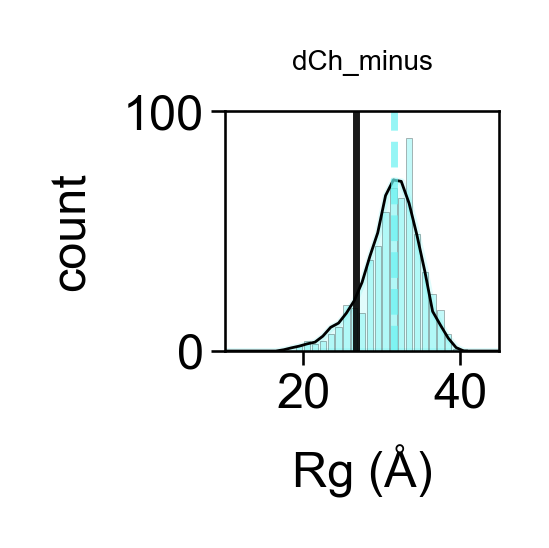

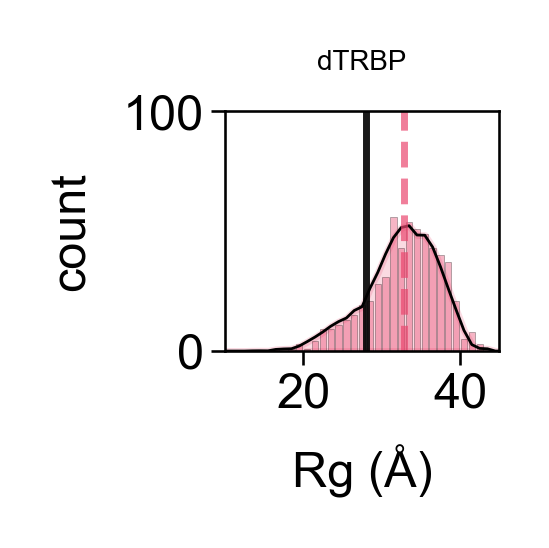

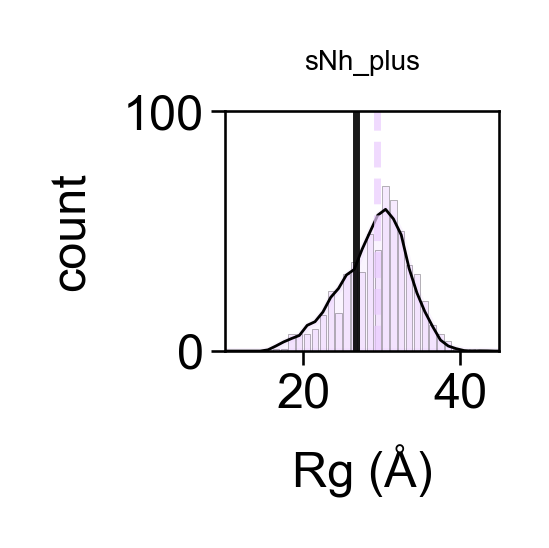

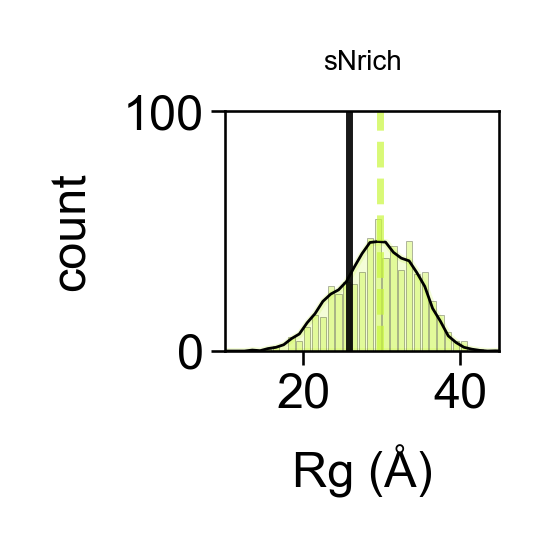

In [25]:
def get_histogram_vals(vals, bw=1, bmin=0,bmax=50, wl=8, polyorder=3):
    
    bins = np.arange(bmin,bmax,bw)
    [a,b]= np.histogram(vals,bins=bins)
    
    smoothed = savgol_filter(a,wl,polyorder)

    smoothed[smoothed<0]=0
    return b[1:]-bw*0.5, a, smoothed

def plot_histo(n, fn, color):        
    figure(None, (1.2, 1.2), dpi=250)
    ax = plt.gca()
    bw=1
    X = get_histogram_vals(idpfold_rgs_all[n], bw=bw)
    
    plt.plot(X[0],X[2], color='k', lw=0.4)
    plt.fill_between(X[0], 0, X[2], alpha=0.2, color=color)
    plt.bar(X[0],X[1], width=bw*0.8, color=color,alpha=0.4, edgecolor='k',lw=0.1)
    plt.ylim([0,100])
    plt.xlim([10,45])
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.ylabel('count', fontsize=7)
    plt.xlabel('Rg (Å)', fontsize=7)
    plt.title(n, fontsize=4)
    ax.axvline(saxs_rg_values[n], color='k',lw=1, alpha=0.9)
    ax.axvline(np.mean(idpfold_rgs_all[n]), color=color,lw=1, alpha=0.7,ls='--')
    
    plt.tight_layout()
    plt.savefig(fn)

for n in seqs:    
    plot_histo(n,'figures/rg_dist_'+n+'.pdf', schuler_colors[n])
    
    
    